## Transfer Learning VGG 16 and VGG 19 using Keras

Please download the dataset from the below url

In [1]:
!nvidia-smi

Sun Aug 13 14:44:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8     2W /  N/A |     59MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\saad4\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [38]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [39]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [40]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'


In [41]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [42]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [43]:
  # useful for getting number of output classes
folders = glob('Datasets/train/*')

In [44]:
folders

['Datasets/train\\cloudy',
 'Datasets/train\\foggy',
 'Datasets/train\\rainy',
 'Datasets/train\\shine',
 'Datasets/train\\sunrise']

In [45]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [46]:
len(folders)

5

In [47]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [48]:

# view the structure of the model
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [49]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [50]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [51]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1500 images belonging to 5 classes.


In [52]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 30 images belonging to 5 classes.


In [54]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\saad4\AppData\Local\Temp\ipykernel_12736\3647634377.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/2
47/47 [==============================] - 126s 3s/step - loss: 0.6503 - accuracy: 0.7553 - val_loss: 0.2729 - val_accuracy: 0.9000
Epoch 2/2
47/47 [==============================] - 119s 3s/step - loss: 0.3097 - accuracy: 0.8927 - val_loss: 0.2246 - val_accuracy: 0.9333


In [55]:
import matplotlib.pyplot as plt

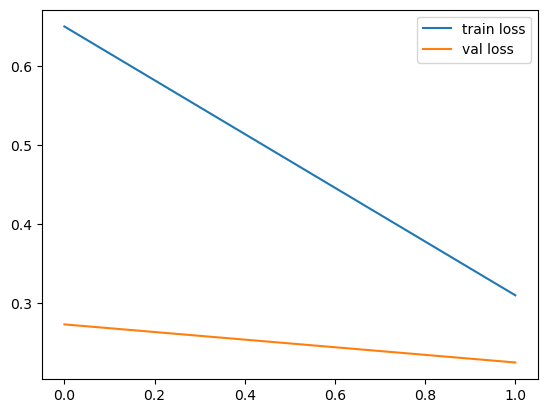

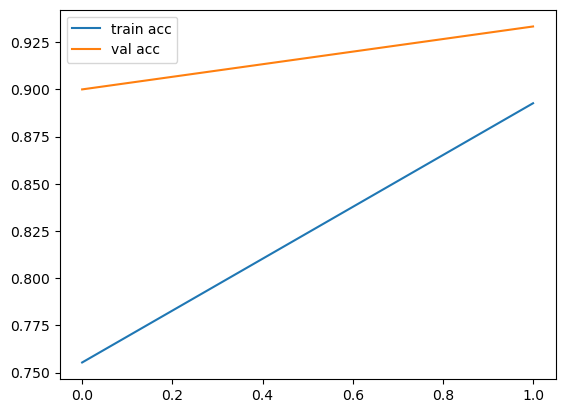

<Figure size 640x480 with 0 Axes>

In [56]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [57]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [58]:

y_pred = model.predict(test_set)


1/1 [==============================] - 2s 2s/step


In [59]:
y_pred

array([[9.37260552e-07, 3.22584150e-04, 9.99670863e-01, 5.27129396e-06,
        3.94485710e-07],
       [8.29433731e-04, 6.89826033e-04, 8.49214941e-03, 3.22027691e-02,
        9.57785785e-01],
       [9.28089768e-03, 9.41820860e-01, 3.01145893e-02, 9.26160067e-03,
        9.52207297e-03],
       [5.44926599e-02, 8.30251992e-01, 8.87291133e-02, 1.07351942e-02,
        1.57911032e-02],
       [3.14346142e-02, 9.30700958e-01, 1.89523380e-02, 7.20817270e-03,
        1.17038917e-02],
       [1.33487089e-02, 2.50246405e-04, 3.13965837e-04, 2.02472694e-03,
        9.84062374e-01],
       [2.91137509e-02, 2.60274075e-02, 9.19779718e-01, 2.49466728e-02,
        1.32406203e-04],
       [7.35262334e-01, 4.61923919e-04, 1.72994986e-01, 9.11456048e-02,
        1.35138223e-04],
       [9.05847490e-01, 2.18835225e-06, 2.56766449e-03, 9.15036649e-02,
        7.89904298e-05],
       [1.43946428e-03, 1.03748862e-05, 2.28984005e-04, 9.97028410e-01,
        1.29274710e-03],
       [1.46898665e-05, 7.7158

In [60]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [61]:
y_pred

array([2, 4, 1, 1, 1, 4, 2, 0, 0, 3, 2, 4, 3, 1, 0, 3, 2, 1, 1, 1, 2, 4,
       3, 4, 2, 1, 1, 4, 2, 4], dtype=int64)

In [103]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [104]:
model=load_model('model_vgg16.h5')

In [30]:
img_data

NameError: name 'img_data' is not defined

In [106]:
img=image.load_img('Datasets/test/cloudy/cloudy_5.jpg',target_size=(224,224))



In [107]:
x=image.img_to_array(img)
x

array([[[ 52.,  55.,  60.],
        [ 51.,  54.,  61.],
        [ 52.,  55.,  64.],
        ...,
        [ 24.,  29.,  32.],
        [ 25.,  30.,  33.],
        [ 24.,  29.,  32.]],

       [[ 56.,  59.,  66.],
        [ 53.,  56.,  63.],
        [ 52.,  55.,  64.],
        ...,
        [ 26.,  31.,  34.],
        [ 26.,  31.,  34.],
        [ 24.,  29.,  32.]],

       [[ 57.,  60.,  67.],
        [ 55.,  58.,  65.],
        [ 52.,  55.,  64.],
        ...,
        [ 26.,  31.,  34.],
        [ 26.,  31.,  34.],
        [ 25.,  30.,  33.]],

       ...,

       [[107., 106., 111.],
        [103., 102., 107.],
        [102., 101., 106.],
        ...,
        [ 84.,  83.,  89.],
        [ 84.,  83.,  89.],
        [ 85.,  84.,  89.]],

       [[112., 112., 114.],
        [105., 105., 107.],
        [107., 106., 111.],
        ...,
        [ 82.,  81.,  87.],
        [ 81.,  80.,  85.],
        [ 83.,  82.,  87.]],

       [[113., 111., 114.],
        [112., 112., 114.],
        [112., 1

In [108]:
x.shape

(224, 224, 3)

In [109]:
x=x/255

In [110]:
import numpy as np
x=np.expand_dims(x,axis=0)
#img_data=preprocess_input(x)
#img_data.shape

In [111]:
model.predict(x)

1/1 [==============================] - 0s 245ms/step


array([[9.9781919e-01, 5.7263082e-06, 1.4733041e-03, 5.9577101e-04,
        1.0597789e-04]], dtype=float32)

In [112]:
a=np.argmax(model.predict(x), axis=1)


1/1 [==============================] - 0s 107ms/step


In [113]:
if a[0]==0:
    print("The image classified is cloudy")
elif a[0]==1:
    print("The image classified is foggy")
elif a[0]==2:
    print("The image classified is rainy")
elif a[0]==3:
    print("The image classified is shine")
else:
    print("The image classified is sunrise")

The image classified is cloudy


In [18]:
import tensorflow as tf

In [19]:
tf.__version__

'2.2.0'